# Credit Card Fraud Detection Analysis

The purpose of this project is to find the best method to detect credit card fraud for customers to avoid getting charged for items they did not purchase. This dataset was originated from credit card transactions in September 2013 by European cardholders. The source of this dataset is from Kaggle and the numerical input variables are the result of a PCA transformation. The original features and background information about the data are not provided due to confidentiality. The Time and Amount features were not transformed. For the Class variable, it's the target variable where 1 is for fraud and 0 otherwise.

In [2]:
# Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, precision_score, recall_score, f1_score
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
import xgboost as xgb

In [20]:
# Read in dataset
creditcarddata = pd.read_csv('creditcard.csv')

## Exploratory Data Analysis/Feature Engineering

* The Time feature is the seconds elapsed between each transaction and the first transaction in the dataset. 
* The Amount feature is the transaction amount. 
* There are duplicates in the data, therefore, we will remove those rows to avoid misleading information. 
* We scale the Time and Amount features to bring them to the same level of magnitudes.
* We check for multicollinearity with our correlation chart and proceed with our analysis since there seems to be no strong associations.
* We check for class imbalance since there would be very few fraud cases in general.

In [21]:
# Checking the first 5 rows of the data
pd.set_option('display.max_columns', None)
creditcarddata.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [22]:
# Dimensions of the dataset
creditcarddata.shape

(284807, 31)

In [23]:
# Checking if there are any nulls
creditcarddata.isnull().sum().max()

0

In [24]:
# Information about the dataset
creditcarddata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [25]:
# Check how many duplicated values there are
creditcarddata.duplicated().sum()

1081

In [26]:
# dropping duplicates to avoid misleading information
creditcarddata = creditcarddata.drop_duplicates()

In [27]:
# Now there are no more duplicates
creditcarddata.duplicated().sum()

0

In [28]:
# Descriptive statistics
creditcarddata.describe(include='all')

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,94811.077600,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,-0.001441,0.000202,-0.000715,0.000603,0.000252,0.001043,0.001162,0.000170,0.001515,-0.000264,0.000187,-0.000371,-0.000015,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547,88.472687,0.001667
std,47481.047891,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,1.076407,1.018720,0.994674,0.995430,0.952215,0.914894,0.873696,0.842507,0.837378,0.813379,0.769984,0.723909,0.724550,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027,250.399437,0.040796
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,-4.797473,-18.683715,-5.791881,-19.214325,-4.498945,-14.129855,-25.162799,-9.498746,-7.213527,-54.497720,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54204.750000,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,-0.535578,-0.761649,-0.406198,-0.647862,-0.425732,-0.581452,-0.466860,-0.483928,-0.498014,-0.456289,-0.211469,-0.228305,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,5.600000,0.000000
50%,84692.500000,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,-0.093237,-0.032306,0.139072,-0.012927,0.050209,0.049299,0.067119,-0.065867,-0.002142,0.003367,-0.062353,-0.029441,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,22.000000,0.000000
75%,139298.000000,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,0.453619,0.739579,0.616976,0.663178,0.492336,0.650104,0.523512,0.398972,0.501956,0.458508,0.133207,0.186194,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,77.510000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,23.745136,12.018913,7.848392,7.126883,10.526766,8.877742,17.315112,9.253526,5.041069,5.591971,39.420904,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


In [29]:
# Scale Amount and Time
standard_scaler = StandardScaler()

creditcarddata['scaled_amt'] = \
    standard_scaler.fit_transform(creditcarddata['Amount'].values.reshape(-1,1))
creditcarddata['scaled_time'] = \
    standard_scaler.fit_transform(creditcarddata['Time'].values.reshape(-1,1))

creditcarddata.drop(['Amount', 'Time'], axis=1, inplace=True)

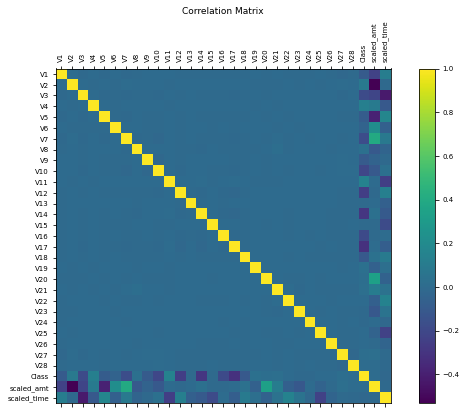

In [19]:
# Correlation Matrix
cor = creditcarddata.corr()
f = plt.figure(figsize=(10,6))
plt.matshow(cor, fignum=f.number)
plt.xticks(range(len(cor.columns)), cor.columns, fontsize=7,rotation = 90)
plt.yticks(range(len(cor.columns)), cor.columns, fontsize=7)
cb = plt.colorbar()
cb.ax.tick_params(labelsize = 7)
plt.title('Correlation Matrix', fontsize = 9)
plt.show()

Class
0    283253
1       473
dtype: int64

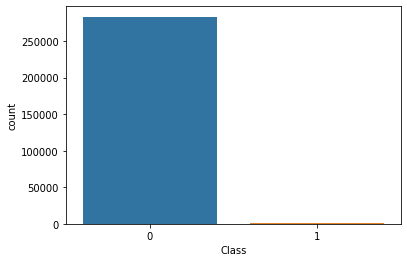

In [13]:
# There is a class imbalance since there are very few fraud transactions
sns.countplot(x = creditcarddata['Class'], data=creditcarddata)
creditcarddata.groupby(['Class']).size()

## Adjusting Imbalanced Feature
Will use SMOTE (Synthetic Minority Oversampling Technique) which takes the minority class and synthesizes new examples. We will also undersample the majority class to balance out the data.

We are performing SMOTE only on the training data because we do not want the synthetic examples to be perfectly copied over to the test data, which would artificially boost our model scores.


In [14]:
# Splitting our data between target variable as y and \
# not target variables as X
X = creditcarddata.drop(['Class'], axis=1)
y = creditcarddata['Class']

In [15]:
# Training data is 80% of the data and \
# Testing data is 20% of the data
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.2, random_state = 0)

In [16]:
print('X training data: ', X_train.shape,'; ', \
    'y training data: ', y_train.shape,'; ', \
        'X testing data: ', X_test.shape,'; ', \
            'y testing data: ', y_test.shape)

X training data:  (226980, 30) ;  y training data:  (226980,) ;  X testing data:  (56746, 30) ;  y testing data:  (56746,)


In [17]:
# rebalancing target variable only on training data \
# because want to avoid artificially boosting model scores
counter = Counter(y_train)
print('Before', counter)
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X_train, y_train = pipeline.fit_resample(X_train, y_train)
counter = Counter(y_train)
print('After',counter)

Before Counter({0: 226594, 1: 386})
After Counter({0: 45318, 1: 22659})


## Modelling

For modelling, I will use XGBoost, MLPClassifier, and Random Forest, and see which model fits best with the data we have. 

### Note about the different scores

Accuracy: The ratio of the total number of correctly predicted samples by the total number of samples.

Precision: The ratio of true positives by the sum of true positives and false positives.

Recall: The ratio of true positives by the sum of true positives and false negatives.

F1 Score: Harmonic mean of precision and recall.

Having a False Negative would be bad as it's predicted to not have a fraudulent transaction, but it actually is. Thus, we will mainly focus on the Recall score, but we want a good balance between all scores because having too many False Positives will cause customers to be flagged unnecessarily for fraud when there was no fraud.


In [18]:
# XGBoost
xgb_model = xgb.XGBClassifier(random_state=0, objective='binary:logistic')
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

print(confusion_matrix(y_test, y_pred_xgb))

[[56597    62]
 [   13    74]]


In [19]:
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb)}")
print(f"Precision: {precision_score(y_test, y_pred_xgb)}")
print(f"Recall Score: {recall_score(y_test, y_pred_xgb)}")
print(f"F1 Score: {f1_score(y_test, y_pred_xgb)}")

Accuracy: 0.9986783209389208
Precision: 0.5441176470588235
Recall Score: 0.8505747126436781
F1 Score: 0.663677130044843


In [26]:
# MLPClassifier
mlp = MLPClassifier()
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)
print(confusion_matrix(y_test, y_pred_mlp))

[[56589    70]
 [   15    72]]


In [27]:
print(f"Accuracy: {accuracy_score(y_test, y_pred_mlp)}")
print(f"Precision: {precision_score(y_test, y_pred_mlp)}")
print(f"Recall Score: {recall_score(y_test, y_pred_mlp)}")
print(f"F1 Score: {f1_score(y_test, y_pred_mlp)}")

Accuracy: 0.9985020970641102
Precision: 0.5070422535211268
Recall Score: 0.8275862068965517
F1 Score: 0.62882096069869


In [47]:
# random forest
clf_rf = RandomForestClassifier(random_state=0)

clf_rf.fit(X_train, y_train)

y_pred_rf = clf_rf.predict(X_test)

print(confusion_matrix(y_test, y_pred_rf))

[[56627    32]
 [   13    74]]


In [23]:
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(f"Precision: {precision_score(y_test, y_pred_rf)}")
print(f"Recall Score: {recall_score(y_test, y_pred_rf)}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf)}")

Accuracy: 0.9992069925633524
Precision: 0.6981132075471698
Recall Score: 0.8505747126436781
F1 Score: 0.7668393782383419


In [1]:
# Grid Search for random forest
'''
clf_rf_gs = RandomForestClassifier(random_state=0)
params_rf = {
    'max_depth': [10, 50, 70, None],
    'n_estimators': [100, 200, 500],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 5, 10]
}

rf_model_gs = GridSearchCV(clf_rf_gs, param_grid=params_rf, \
    cv = 5, scoring = "recall", n_jobs=-1)
rf_model_gs.fit(X_train, y_train)
print(rf_model_gs.best_params_)
# best parameters: max_depth: 50, n_estimators: 200, min_samples_leaf: 1, \
# min_samples_split: 2
'''

'\nclf_rf_gs = RandomForestClassifier(random_state=0)\nparams_rf = {\n    \'max_depth\': [10, 50, 70, None],\n    \'n_estimators\': [100, 200, 500],\n    \'min_samples_leaf\': [1, 3, 5],\n    \'min_samples_split\': [2, 5, 10]\n}\n\nrf_model_gs = GridSearchCV(clf_rf_gs, param_grid=params_rf, cv = 5, scoring = "recall", n_jobs=-1)\nrf_model_gs.fit(X_train, y_train)\n# min_samples_leaf: 2, n_estimators: 200, max_depth: 50, min_samples_split: 6\nprint(rf_model_gs.best_params_)\n# best parameters: max_depth: 50, n_estimators: 200, min_samples_leaf: 1, min_samples_split: 2\n'

In [52]:
clf_rf_best = RandomForestClassifier(random_state=0, max_depth=50, \
    n_estimators=200, min_samples_leaf=1, min_samples_split=2)

clf_rf_best.fit(X_train, y_train)

y_pred_rf_best = clf_rf_best.predict(X_test)

print(confusion_matrix(y_test, y_pred_rf_best))

[[56628    31]
 [   13    74]]


In [53]:
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf_best)}")
print(f"Precision: {precision_score(y_test, y_pred_rf_best)}")
print(f"Recall Score: {recall_score(y_test, y_pred_rf_best)}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf_best)}")

Accuracy: 0.9992246149508336
Precision: 0.7047619047619048
Recall Score: 0.8505747126436781
F1 Score: 0.7708333333333334


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


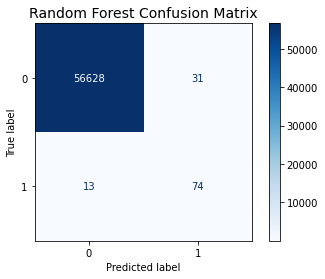

In [54]:
plot_confusion_matrix(clf_rf_best, X_test, y_test, cmap = 'Blues')
plt.title('Random Forest Confusion Matrix', fontsize = 14)
plt.show()

# Results

After running the initial models with default parameters for all three, I decided to proceed with Random Forest since it provided the best initial result in terms of the balance of all scores. Although the recall score is already about 85.1 percent, I wanted to see if overall the scores could be improved. 

I proceeded with grid search, where I searched for the best parameters for this random forest model. The parameters I did a grid search for are max_depth, n_estimators, min_samples_leaf, and min_samples_split. After performing a grid search, I found the best parameters to be 50 for max depth, 200 for n_estimators, 1 for min_samples_leaf, and 2 for min_samples_split. With this, accuracy is about 99.9%, the recall score is about 85.1%, the precision score is about 70.4%, and the f1-score is about 77.1%. In this case, we are finding a healthy balance between predicting false negatives and false positives.

With this model, we can prevent many customers from experiencing fraud transactions and also prevent customers from being flagged for fraud unnecessarily. 